In [1]:
import numpy as np
import pickle
import glob
from time import time
import cv2
import copy
import math
import itertools
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from scipy import ndimage as ndi
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Load data

In [2]:
car_images = glob.glob('data/vehicles/*/*.png')
not_car_images = glob.glob('data/non-vehicles/*/*.png')

print("Number of car images: %d" % len(car_images))
print("Number of not car images: %d" % len(not_car_images))

Number of car images: 8792
Number of not car images: 8968


## Display images

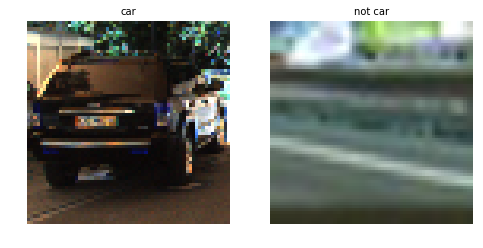

In [496]:
fig, axs = plt.subplots(1,2, figsize=(8, 8))
axs = axs.ravel()

img_examples = [cv2.imread(car_images[np.random.randint(0, len(car_images))]), 
       cv2.imread(not_car_images[np.random.randint(0,len(not_car_images))])]
img_labels = ['car', 'not car']

for i in np.arange(2):
    img = img_examples[i]
    axs[i].axis('off')
    axs[i].set_title(img_labels[i], fontsize=10)
    axs[i].imshow(img, cmap='gray')

## Extract HOG features and visualize

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """Extract HOG features from image
    
    Parameters
    ----------
    img : numpy array
        Input image
    
    orient : int
        Number of orientation bins
    
    pix_per_cell : 2-tuple of ints
        Size of cell (in pixels)
    
    cell_per_block : 2-tuple of ints
        Number of cells in each block
    
    vis : boolean
        Flag for whether or not to return vis
    
    feature_vec : boolean
        Whether to return data as a feature vector by calling .ravel() on result
    
    Returns
    -------
    features : numpy array
        HOG descriptor (n_blocks_row, n_blocks_col, n_cells_row, n_cells_col, n_orient)
        If feature_vector is True, a 1D (flattened) array is returned.

    hog_image : (M, N) ndarray, optional
        Visualization of HOG image. 
        Only provided if visualize is True.
    """
    # Return two features + img if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise return just features
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

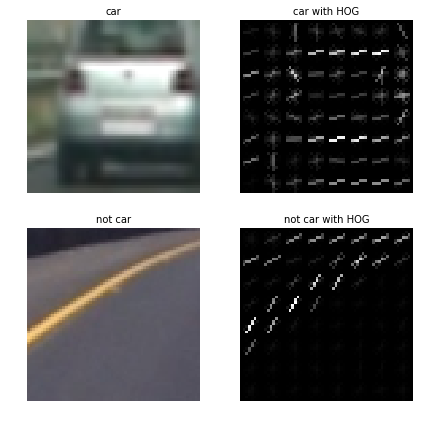

In [5]:
fig, axs = plt.subplots(2,2, figsize=(7, 7))
axs = axs.ravel()

car_example = mpimg.imread(car_images[100])
car_example_gray = cv2.cvtColor(car_example, cv2.COLOR_BGR2GRAY)
car_feat, car_hog_img = get_hog_features(car_example_gray, 9, 8, 2, True, True)

not_car_example = mpimg.imread(not_car_images[10])
not_car_example_gray = cv2.cvtColor(not_car_example, cv2.COLOR_BGR2GRAY)
not_car_feat, not_car_hog_img = get_hog_features(not_car_example_gray, 9, 8, 2, True, True)

hog_examples = [car_example, car_hog_img, not_car_example, not_car_hog_img]
hog_examples_labels = ["car", "car with HOG", "not car", "not car with HOG"]
for i in np.arange(4):
    img = hog_examples[i]
    axs[i].axis('off')
    axs[i].set_title(hog_examples_labels[i], fontsize=10)
    axs[i].imshow(img, cmap='gray')

In [4]:
def bin_spatial(img, size=(64, 64)):
    """Compute binned color features
    
    Parameters
    ----------
    img : numpy array
        Original image
        
    size : 2-tuple of ints
        Dimensions to resize image
    
    Returns
    -------
    features : 1D (flattened) array
        HOG feature vector
    """
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    return features

In [5]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    """Compute color histogram features
    
    Parameters
    ----------
    img : numpy array
        Input image
    
    nbins : int
        Number of bins
    
    bins_range : 2-tuple of ints
        Range of bins
    
    Returns
    -------
    hist_features : numpy array
        Individual histograms, bin_centers, and feature vector concatenated into an array
    """
    # Compute the histogram of the color channels separately
    channel_1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel_2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel_3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel_1_hist[0], channel_2_hist[0], channel_3_hist[0]))
    return hist_features

In [6]:
def convert_color_space(image, color_space='YCrCb'):
    """Convert an image's color space
    
    Parameters
    ----------
    img : numpy array
        Input image
    
    color_space : str
        Colorspace for output image
    
    Returns
    -------
    converted_img : numpy array
        Image with converted colorspace
    """
    feature_image = np.copy(image)

    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

    return feature_image

In [7]:
def extract_features_from_files(imgs, feature_param_dict):
    """Extract HOG features from a list of images
    
    Parameters
    ----------
    imgs : list of str
        list of image names
    
    feature_param_dict : dict
        dictionary with all the feature parameters (color_space, spatial_size, 
                                                    hist_bins, hist_range, orient,
                                                    pix_per_cell, cell_per_block, hog_channel,
                                                    spatial_feat, hist_feat, hog_feat)
    
    Returns
    -------
    features : numpy array
        Array of features to describe the image
    """
    color_space = feature_param_dict['color_space']
    spatial_size = feature_param_dict['spatial_size']
    hist_bins = feature_param_dict['hist_bins']
    hist_range = feature_param_dict['hist_range']
    orient = feature_param_dict['orient']
    pix_per_cell = feature_param_dict['pix_per_cell']
    cell_per_block = feature_param_dict['cell_per_block']
    hog_channel = feature_param_dict['hog_channel']
    spatial_feat = feature_param_dict['spatial_feat']
    hist_feat = feature_param_dict['hist_feat']
    hog_feat = feature_param_dict['hog_feat']
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        # Convert image's color space
        feature_image = convert_color_space(image, color_space)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Extract Features for SVM and Split Train/Test Data

In [8]:
# create feature parameter gridsearch
extract_param_dict = {}
for i in enumerate(itertools.product(['RGB', 'YCrCb'], [8, 9], [8, 16])):
    extract_param_dict[i[0]] = {'color_space': i[1][0], 'spatial_size': (16, 16), 'hist_bins': 16,
                         'hist_range': (0, 256), 'orient': i[1][1], 'pix_per_cell': i[1][2], 'cell_per_block': 2,
                         'hog_channel': 'ALL', 'spatial_feat': True, 'hist_feat': True, 'hog_feat': True}

In [9]:
# perform feature parameter gridsearch and store train, test sets
training_dict = {}

for counter, feat_dict in extract_param_dict.items():
    print("Counter: %d" % counter)
    print("Features: %s" % feat_dict)
    t0 = time()
    car_features = extract_features_from_files(car_images, feat_dict)
    not_car_features = extract_features_from_files(not_car_images, feat_dict)
    X = np.vstack((car_features, not_car_features)).astype(np.float64)
    # standardize features with per-column sklearn scaler 
    feature_scaler = StandardScaler().fit(X)
    scaled_X = feature_scaler.transform(X)
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))
    # Split up data into randomized training and test sets
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=0)
    training_dict[counter] = (X_train, X_test, y_train, y_test)
    print("Done in %0.3fs" % (time() - t0))

Counter: 0
Features: {'hog_feat': True, 'hist_range': (0, 256), 'orient': 8, 'spatial_feat': True, 'hist_bins': 16, 'cell_per_block': 2, 'hog_channel': 'ALL', 'color_space': 'RGB', 'spatial_size': (16, 16), 'hist_feat': True, 'pix_per_cell': 8}
Done in 60.000s
Counter: 1
Features: {'hog_feat': True, 'hist_range': (0, 256), 'orient': 8, 'spatial_feat': True, 'hist_bins': 16, 'cell_per_block': 2, 'hog_channel': 'ALL', 'color_space': 'RGB', 'spatial_size': (16, 16), 'hist_feat': True, 'pix_per_cell': 16}
Done in 40.653s
Counter: 2
Features: {'hog_feat': True, 'hist_range': (0, 256), 'orient': 9, 'spatial_feat': True, 'hist_bins': 16, 'cell_per_block': 2, 'hog_channel': 'ALL', 'color_space': 'RGB', 'spatial_size': (16, 16), 'hist_feat': True, 'pix_per_cell': 8}
Done in 58.945s
Counter: 3
Features: {'hog_feat': True, 'hist_range': (0, 256), 'orient': 9, 'spatial_feat': True, 'hist_bins': 16, 'cell_per_block': 2, 'hog_channel': 'ALL', 'color_space': 'RGB', 'spatial_size': (16, 16), 'hist_fea

## Train and Test SVM

In [14]:
# train and test for vanilla SVM with default params
svm_dict = {}

for key, feat_tuple in features_dict.items():
    print("Counter: %d" % key)
    t0 = time()
    X_train, X_test, y_train, y_test = feat_tuple
    
    # Create the classifier
    svc = LinearSVC()
    
    # Train the classifier
    t0 = time()
    svc.fit(X_train, y_train)
    print("Training time of SVC: %0.3fs" % (time()-t0))
    
    # Check accuracy
    acc = svc.score(X_test, y_test)
    print('Test Accuracy of SVC: %0.4f' % acc)
    svm_dict[key] = acc
    print("Done in %0.3fs" % (time() - t0))

Counter: 0
Training time of SVC: 15.094s
Test Accuracy of SVC: 0.9738
Done in 15.121s
Counter: 1
Training time of SVC: 3.765s
Test Accuracy of SVC: 0.9764
Done in 3.779s
Counter: 2
Training time of SVC: 15.102s
Test Accuracy of SVC: 0.9775
Done in 15.127s
Counter: 3
Training time of SVC: 3.610s
Test Accuracy of SVC: 0.9761
Done in 3.617s
Counter: 4
Training time of SVC: 10.007s
Test Accuracy of SVC: 0.9870
Done in 10.029s
Counter: 5
Training time of SVC: 2.293s
Test Accuracy of SVC: 0.9811
Done in 2.301s
Counter: 6
Training time of SVC: 3.024s
Test Accuracy of SVC: 0.9856
Done in 3.048s
Counter: 7
Training time of SVC: 2.529s
Test Accuracy of SVC: 0.9840
Done in 2.537s


In [15]:
# train and test SVM with param `c` = 0.005
svm_c_dict = {}

for key, feat_tuple in features_dict.items():
    print("Counter: %d" % key)
    t0 = time()
    X_train, X_test, y_train, y_test = feat_tuple
    
    # Create the classifier
    svc = LinearSVC(C=0.005)
    
    # Train the classifier
    t0 = time()
    svc.fit(X_train, y_train)
    print("Training time of SVC: %0.3fs" % (time()-t0))
    
    # Check accuracy
    acc = svc.score(X_test, y_test)
    print('Test Accuracy of SVC: %0.4f' % acc)
    svm_c_dict[key] = acc
    print("Done in %0.3fs" % (time() - t0))

Counter: 0
Training time of SVC: 6.695s
Test Accuracy of SVC: 0.9755
Done in 6.718s
Counter: 1
Training time of SVC: 2.992s
Test Accuracy of SVC: 0.9764
Done in 2.999s
Counter: 2
Training time of SVC: 10.116s
Test Accuracy of SVC: 0.9778
Done in 10.141s
Counter: 3
Training time of SVC: 2.124s
Test Accuracy of SVC: 0.9792
Done in 2.132s
Counter: 4
Training time of SVC: 3.795s
Test Accuracy of SVC: 0.9870
Done in 3.817s
Counter: 5
Training time of SVC: 1.620s
Test Accuracy of SVC: 0.9848
Done in 1.633s
Counter: 6
Training time of SVC: 5.377s
Test Accuracy of SVC: 0.9862
Done in 5.401s
Counter: 7
Training time of SVC: 1.599s
Test Accuracy of SVC: 0.9870
Done in 1.607s


In [16]:
extract_param_dict

{0: {'cell_per_block': 2,
  'color_space': 'RGB',
  'hist_bins': 16,
  'hist_feat': True,
  'hist_range': (0, 256),
  'hog_channel': 'ALL',
  'hog_feat': True,
  'orient': 8,
  'pix_per_cell': 8,
  'spatial_feat': True,
  'spatial_size': (16, 16)},
 1: {'cell_per_block': 2,
  'color_space': 'RGB',
  'hist_bins': 16,
  'hist_feat': True,
  'hist_range': (0, 256),
  'hog_channel': 'ALL',
  'hog_feat': True,
  'orient': 8,
  'pix_per_cell': 16,
  'spatial_feat': True,
  'spatial_size': (16, 16)},
 2: {'cell_per_block': 2,
  'color_space': 'RGB',
  'hist_bins': 16,
  'hist_feat': True,
  'hist_range': (0, 256),
  'hog_channel': 'ALL',
  'hog_feat': True,
  'orient': 9,
  'pix_per_cell': 8,
  'spatial_feat': True,
  'spatial_size': (16, 16)},
 3: {'cell_per_block': 2,
  'color_space': 'RGB',
  'hist_bins': 16,
  'hist_feat': True,
  'hist_range': (0, 256),
  'hog_channel': 'ALL',
  'hog_feat': True,
  'orient': 9,
  'pix_per_cell': 16,
  'spatial_feat': True,
  'spatial_size': (16, 16)},
 4

Model with highest accuracy and fastest training time: 

* `LinearSVC(C=0.005)` with the features:
  * `{'cell_per_block': 2,
      'color_space': 'YCrCb',
      'hist_bins': 16,
      'hist_feat': True,
      'hist_range': (0, 256),
      'hog_channel': 'ALL',
      'hog_feat': True,
      'orient': 9,
      'pix_per_cell': 16,
      'spatial_feat': True,
      'spatial_size': (16, 16)}`

## Save Model and Features

In [19]:
# dump all stuff necessary to perform testing in a successive phase
with open('data/svm_trained.pickle', 'wb') as f:
    pickle.dump(svc, f)
with open('data/feature_scaler.pickle', 'wb') as f:
    pickle.dump(feature_scaler, f)
with open('data/feat_extraction_params.pickle', 'wb') as f:
    pickle.dump(feat_extraction_params, f)

In [449]:
def detect_cars(img, y_start, y_stop, scale_factor, clf, std_scaler, feature_param_dict, window=64):
    """Use a sliding window to extract features from an image to find cars
    
    Parameters
    ----------
    img : numpy array
        Input image
    
    y_start : int
        Detection area lower bound for y axis
    
    y_stop : int
        Detection area upper bound for y axis
    
    scale_factor : float
        Scaling factor for subsampling image before extracting features
    
    clf : sklearn clf model (LinearSVM)
        Sklearn classification model
    
    scaler : sklearn StandardScaler obj
        Sklearn StandardScaler obj to standardize features
    
    feature_param_dict : dict
        dictionary with all the feature parameters (color_space, spatial_size, 
                                                    hist_bins, hist_range, orient,
                                                    pix_per_cell, cell_per_block, hog_channel,
                                                    spatial_feat, hist_feat, hog_feat)
    
    window : int
        Sampling rate
        
    Returns
    -------
    hot_windows : list of tuples
        List of windows (top-left and bottom-right corners) where cars are detected 
    """
    color_space = feature_param_dict['color_space']
    spatial_size = feature_param_dict['spatial_size']
    hist_bins = feature_param_dict['hist_bins']
    hist_range = feature_param_dict['hist_range']
    orient = feature_param_dict['orient']
    pix_per_cell = feature_param_dict['pix_per_cell']
    cell_per_block = feature_param_dict['cell_per_block']
    hog_channel = feature_param_dict['hog_channel']
    spatial_feat = feature_param_dict['spatial_feat']
    hist_feat = feature_param_dict['hist_feat']
    hog_feat = feature_param_dict['hog_feat']
    
    hot_windows = []
    
    img = img.astype(np.float32)/255
    
    img_window = img[y_start:y_stop, :, :]
    img_window = convert_color_space(img_window, color_space)
    
    # rescale image if other than 1.0 scale
    if scale_factor != 1:
        imshape = img_window.shape
        img_window = cv2.resize(img_window, (np.int(imshape[1]/scale_factor), np.int(imshape[0]/scale_factor)))
    
    feature_image = convert_color_space(img_window, color_space)
    
    # Get each channel
    channel_1 = img_window[:, :, 0]
    channel_2 = img_window[:, :, 1]
    channel_3 = img_window[:, :, 2]
    
    # Compute HOG features for each channel
    hog_1 = get_hog_features(channel_1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog_2 = get_hog_features(channel_2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog_3 = get_hog_features(channel_3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Define blocks and steps
    n_x_blocks = (channel_1.shape[1] // pix_per_cell) - 1
    n_y_blocks = (channel_1.shape[0] // pix_per_cell) - 1 
    n_feat_per_block = orient * cell_per_block**2
    
    n_blocks_per_window = (window // pix_per_cell) - 1 
    cells_per_step = 4  # Instead of overlap, define how many cells to step
    n_x_steps = (n_x_blocks - n_blocks_per_window) // cells_per_step
    n_y_steps = (n_y_blocks - n_blocks_per_window) // cells_per_step
    
    for xb in range(n_x_steps):
        for yb in range(n_y_steps):
            y_pos = yb*cells_per_step
            x_pos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat_1 = hog_1[y_pos:y_pos + n_blocks_per_window, x_pos:x_pos + n_blocks_per_window].ravel()
            hog_feat_2 = hog_2[y_pos:y_pos + n_blocks_per_window, x_pos:x_pos + n_blocks_per_window].ravel() 
            hog_feat_3 = hog_3[y_pos:y_pos + n_blocks_per_window, x_pos:x_pos + n_blocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat_1, hog_feat_2, hog_feat_3))

            x_left = x_pos * pix_per_cell
            y_top = y_pos * pix_per_cell
            
            # Get a region within window
            sub_window = cv2.resize(img_window[y_top:y_top + window, x_left:x_left + window], (64, 64))
            
            spatial_features = bin_spatial(sub_window, size=spatial_size)
            hist_features = color_hist(sub_window, nbins=hist_bins, bins_range=hist_range)
            
            features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            scaled_features = feature_scaler.transform(features)
            
            prediction = clf.predict(scaled_features)
            
            if prediction == 1:
                x_box_left = np.int(x_left * scale_factor)
                y_top_draw = np.int(y_top * scale_factor)
                win_draw = np.int(window*scale_factor)
                hot_windows.append(((x_box_left, y_top_draw + y_start),
                                    (x_box_left + win_draw, y_top_draw + win_draw + y_start)))
                
    return hot_windows

In [112]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """Draw bounding boxes on image
    
    Parameters
    ----------
    img : numpy array
        Input image
    
    bboxes : list of tuples
        List of identified windows
    
    color : 3-tuple of ints
        Color of the box
    
    thick : int
        Line width for box
    
    Returns
    -------
    imcopy : numpy array
        Image with bounding box drawn
    """
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

## Test sliding window approach for detection

Test out different `y_start`, `y_stop`, and `scale_factors` for `detect_cars` function.

In [114]:
test_img = mpimg.imread('./test_images/test1.jpg')

rectangles = detect_cars(test_img, 400, 656, 1.5, svc, feature_scaler, feature_param_dict)

print(len(rectangles), 'rectangles found in image')

1 rectangles found in image


Number of windows:  12


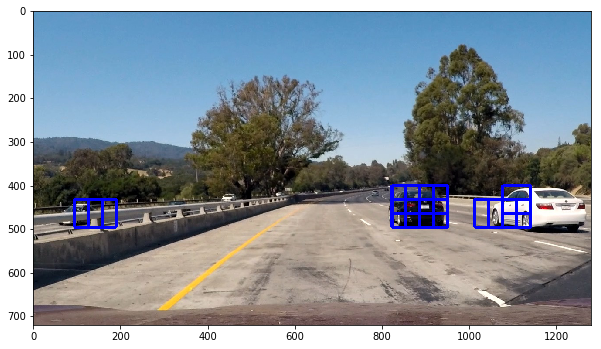

In [267]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

y_start = 400
y_stop = 656
scale_factor = 0.99

rects.append(detect_cars(test_img, y_start, y_stop, scale_factor, svc, feature_scaler, feature_param_dict))

windows = [item for sublist in rects for item in sublist] 
test_img_windows = draw_boxes(test_img, windows)
plt.figure(figsize=(10,10))
plt.imshow(test_img_windows)
print('Number of windows: ', len(windows))

Number of windows:  5


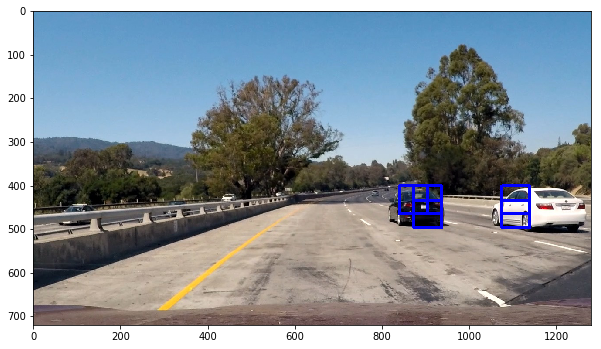

In [274]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

y_start = 400
y_stop = 656
scale_factor = 1.05

rects.append(detect_cars(test_img, y_start, y_stop, scale_factor, svc, feature_scaler, feature_param_dict))

windows = [item for sublist in rects for item in sublist] 
test_img_windows = draw_boxes(test_img, windows)
plt.figure(figsize=(10,10))
plt.imshow(test_img_windows)
print('Number of windows: ', len(windows))

Number of windows:  5


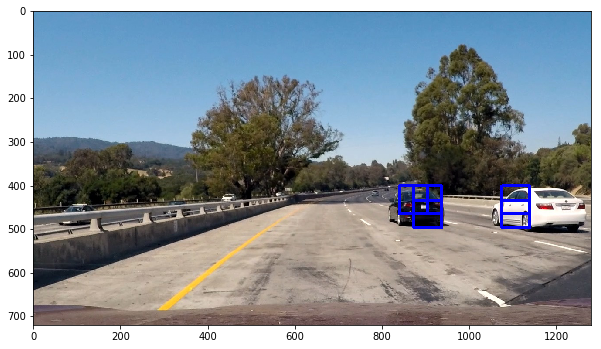

In [302]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

y_start = 400
y_stop = 656
scale_factor = 1.05

rects.append(detect_cars(test_img, y_start, y_stop, scale_factor, svc, feature_scaler, feature_param_dict))

windows = [item for sublist in rects for item in sublist] 
test_img_windows = draw_boxes(test_img, windows)
plt.figure(figsize=(10,10))
plt.imshow(test_img_windows)
print('Number of windows: ', len(windows))

## Create Heatmap and Labeled Areas

Create a heatmap based on the bounding boxes detected, apply a threshold for the heatmap, and add boxes based on labels detected from heatmap.

In [439]:
def create_heatmap(heatmap, windows):
    """Convert windows to heatmap numpy array mask
    
    Parameters
    ----------
    heatmap : numpy array
        Array of 0's to represent image
    
    windows : list of tuples
        List of windows (top-left and bottom-right corners) where cars are detected
    
    Returns
    -------
    background : numpy array
        Heatmap array based on windows
    """
    for window in windows:
        heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    """Apply threshold for pixels in heatmap mask to reject false positives
    
    Parameters
    ----------
    heatmap : numpy array
        Mask representing image with bounding boxes
    
    threshold : int
        Threshold for heatmap mask
    
    Returns
    -------
    heatmap : numpy array
        Mask with threshold applied
    """
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_boxes(img, labels):
    """Draw bounding boxes arounded each labeled area 
    
    Parameters
    ----------
    img : numpy array
        Input image
    
    labels : numpy array
        Label detection areas in heatmap with scipy.ndimage.measurements.label
    
    Returns
    -------
    img : numpy array
        Image with bounding boxes drawn around labeled areas 
    """
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

### Create heatmap mask

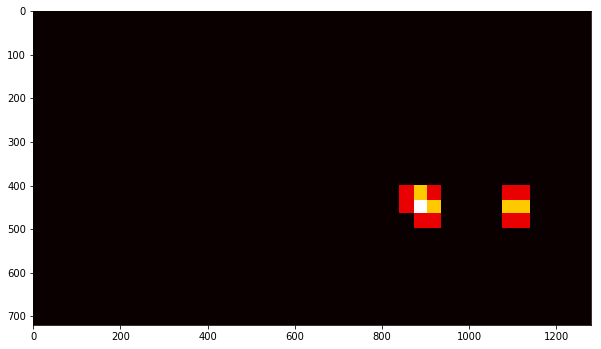

In [278]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = create_heatmap(heatmap_img, windows)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

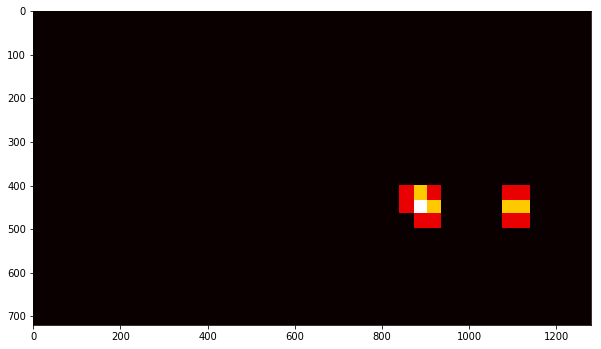

In [279]:
heatmap_img = apply_threshold(heatmap_img, 0.5)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

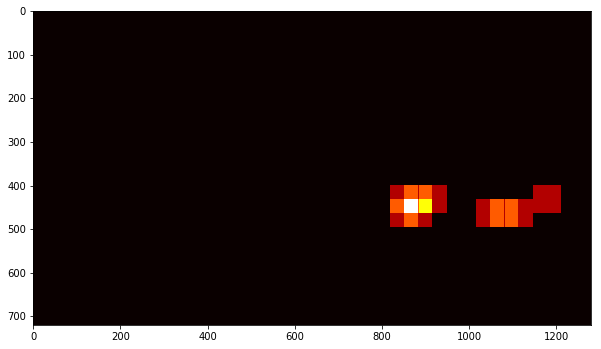

In [255]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = create_heatmap(heatmap_img, windows)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

### Caculate labels

Number of cars detected: 2


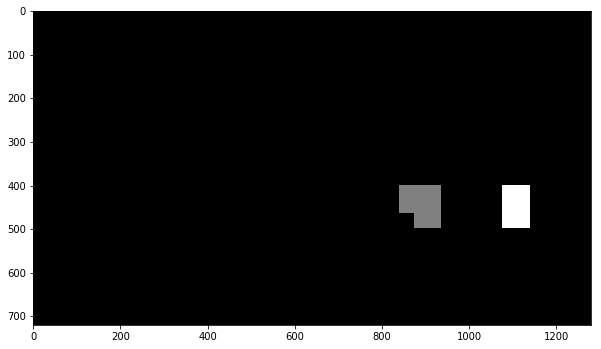

In [280]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print('Number of cars detected: %d' % labels[1])

### Draw bounding boxes

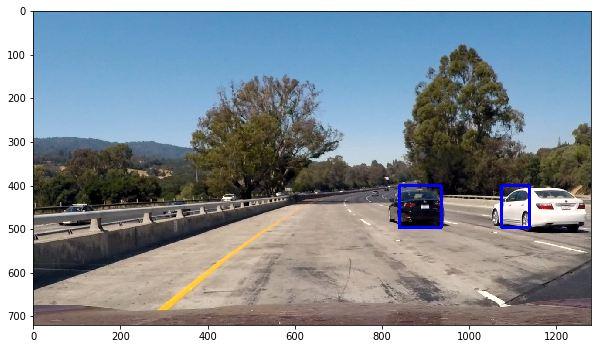

In [281]:
# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_boxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

## Pipeline to process image

In [455]:
def process_image(image, clf=svc, feature_scaler=feature_scaler, feature_param_dict=feature_param_dict, detection_params=detection_params):
    """Pipeline for processing an image to detect cars
    
    Parameters
    ----------
    image : numpy array
        Input image
    
    clf : sklearn clf model (LinearSVM)
        Sklearn classification model
    
    scaler : sklearn StandardScaler obj
        Sklearn StandardScaler obj to standardize features
    
    feature_param_dict : dict
        dictionary with all the feature parameters (color_space, spatial_size, 
                                                    hist_bins, hist_range, orient,
                                                    pix_per_cell, cell_per_block, hog_channel,
                                                    spatial_feat, hist_feat, hog_feat)
    
    detection_params : list of tuples
        List of tuples for sliding window (y_start, y_stop, scale_factor)
    """
    windows = []
    
    for param_combination in detection_params:
        y_start = param_combination[0]
        y_stop = param_combination[1]
        scale_factor = param_combination[2]

        windows.append(detect_cars(image, y_start, y_stop, scale_factor, clf, feature_scaler, feature_param_dict))

    boxes = [item for sublist in windows for item in sublist]
    heatmap_img = np.zeros_like(image[:,:,0])
    heatmap_img = create_heatmap(heatmap_img, boxes)
    heatmap_img = apply_threshold(heatmap_img, 1.5)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_boxes(np.copy(image), labels)
    
    return draw_img

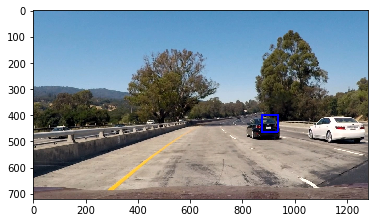

In [448]:
plt.imshow(process_image(mpimg.imread('./test_images/test1.jpg'), svc, feature_scaler, feature_param_dict, [(400,600,1.05)]))

Number of windows:  4


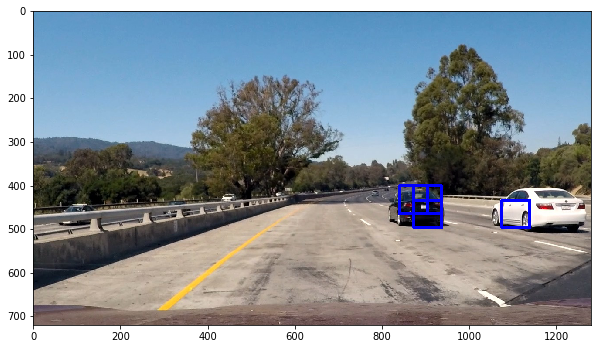

In [445]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

y_start = 400
y_stop = 600
scale_factor = 1.05

rects.append(detect_cars(test_img, y_start, y_stop, scale_factor, svc, feature_scaler, feature_param_dict))

windows = [item for sublist in rects for item in sublist] 
test_img_windows = draw_boxes(test_img, windows)
plt.figure(figsize=(10,10))
plt.imshow(test_img_windows)
print('Number of windows: ', len(windows))

**Test pipeline on test images**

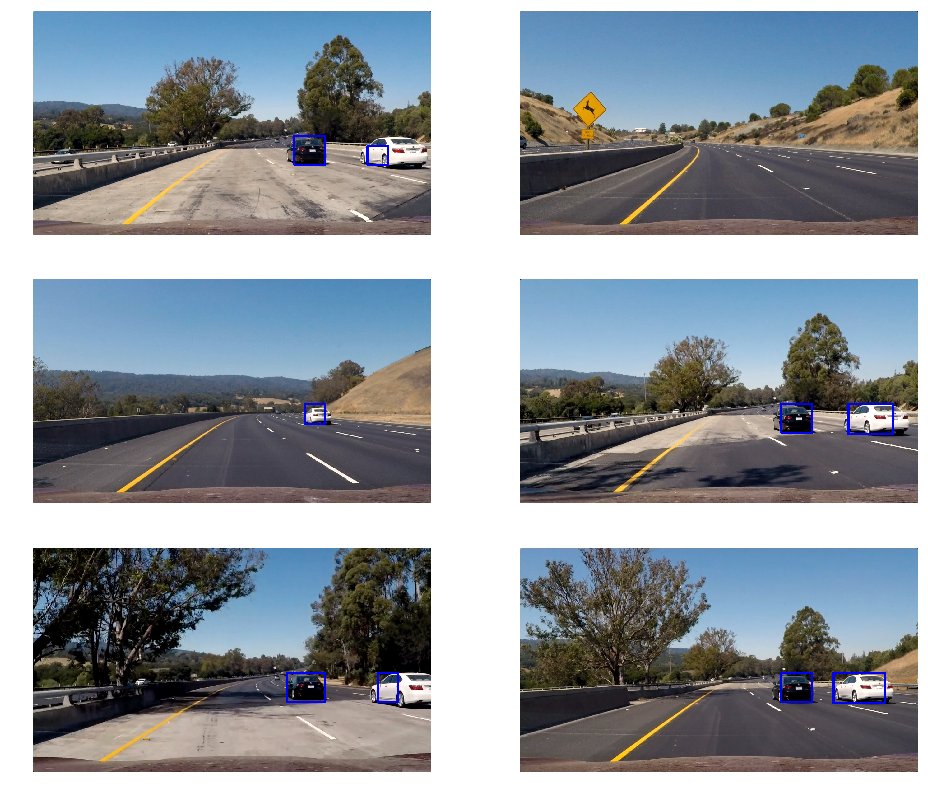

In [457]:
test_images = glob.glob('./test_images/test*.jpg')
detection_params = [(400, 600, 1.05), (400, 700, 1.5)]

fig, axs = plt.subplots(3, 2, figsize=(16,14))
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_image(mpimg.imread(im), svc, feature_scaler, feature_param_dict, detection_params))
    axs[i].axis('off')

## Process video

In [458]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:16<00:00,  2.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 16.2 s, sys: 1.11 s, total: 17.4 s
Wall time: 18.1 s


In [459]:
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [09:05<00:00,  2.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 8min 44s, sys: 30.4 s, total: 9min 15s
Wall time: 9min 7s


In [462]:
from moviepy.editor import *

clip = (VideoFileClip("project_video_out.mp4")
        .subclip((0,26.75),(0,39))
        .resize(0.3))
clip.write_gif("project_video_out.gif")


[MoviePy] Building file project_video_out.gif with imageio


100%|██████████| 307/307 [00:38<00:00,  8.04it/s]
